In [26]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
from sklearn import preprocessing
from helpers import OutlierDetection
from statsmodels.stats.outliers_influence import variance_inflation_factor 
from sklearn.decomposition import PCA 
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor 
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_classif 

import pickle

with open('encoded.pkl','rb') as file:
    labeled=pickle.load(file)
    
labeled.head()

,gender,SeniorCitizen,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,Churn,tenure,MonthlyCharges,TotalCharges
0,0,0,1,0,0,1,0,0,2,0,0,0,0,0,1,2,0,-1.277445,-1.160323,-0.992611
1,1,0,0,0,1,0,0,2,0,2,0,0,0,1,0,3,0,0.066327,-0.259629,-0.172165
2,1,0,0,0,1,0,0,2,2,0,0,0,0,0,1,3,1,-1.236724,-0.362660,-0.958066
3,1,0,0,0,0,1,0,2,0,2,2,0,0,1,0,0,0,0.514251,-0.746535,-0.193672
4,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,2,1,-1.236724,0.197365,-0.938874


## Feature Engineering

Grouping customers by subscription to streaming services

In [27]:
def streaming(row):
        if row['StreamingTV']==1 or row['StreamingMovies']==1:
            return '1'
        else:
            return '0'
    
labeled['StreamingCustomer']=labeled.apply(streaming, axis=1)



In [28]:
labeled=labeled.drop(columns=['StreamingTV', 'StreamingMovies'], axis=1)

Build feature to determine demographics based upon columns 'gender', 'partner', 'dependents' and 'senior citizen'

In [29]:
def demographics(row):
  if row['gender']==0 and row['Partner']==1:
      return 'married woman'
  elif row['gender']==0 and row['Partner']==1 and row['Dependents'] >0:
      return f"married woman with {row['Dependents']} children"
  elif row['gender']==1 and row['Partner']==1 and row['Dependents'] >0:
      return f"married man with {row['Dependents']} children"
  elif row['gender']==1 and row['Partner']==0 and row['Dependents'] >0:
      return f"single man with {row['Dependents']} children"
  elif row['gender']==0 and row['Partner']==0 and row['Dependents'] >0:
      return f"single woman with {row['Dependents']} children"
  elif row['gender']==0 and row['Partner']==0 and row['Dependents'] ==0:
      return 'single woman'
  elif row['gender']==1 and row['Partner']==0 and row['Dependents'] ==0:
      return 'single man'
  elif row['gender']==1 and row['Partner']==0 and row['Dependents'] ==0 and row['SeniorCitizen']==1:
      return 'single senior man'
  elif row['gender']==1 and row['Partner']==1 and row['Dependents'] ==0 and row['SeniorCitizen']==1:
      return 'married senior man'
  elif row['gender']==0 and row['Partner']==0 and row['Dependents'] ==0 and row['SeniorCitizen']==1:
      return 'single senior woman'
  elif row['gender']==0 and row['Partner']==1 and row['Dependents'] ==0 and row['SeniorCitizen']==1:
      return 'married senior woman'
  else:
      return 'person with no label'
  
labeled['Demographic']=labeled.apply(demographics, axis=1)

In [30]:
labeled.head()

,gender,SeniorCitizen,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,Contract,PaperlessBilling,PaymentMethod,Churn,tenure,MonthlyCharges,TotalCharges,StreamingCustomer,Demographic
0,0,0,1,0,0,1,0,0,2,0,0,0,1,2,0,-1.277445,-1.160323,-0.992611,0,married woman
1,1,0,0,0,1,0,0,2,0,2,0,1,0,3,0,0.066327,-0.259629,-0.172165,0,single man
2,1,0,0,0,1,0,0,2,2,0,0,0,1,3,1,-1.236724,-0.362660,-0.958066,0,single man
3,1,0,0,0,0,1,0,2,0,2,2,1,0,0,0,0.514251,-0.746535,-0.193672,0,single man
4,0,0,0,0,1,0,1,0,0,0,0,0,1,2,1,-1.236724,0.197365,-0.938874,0,single woman


In [31]:
labeled=labeled.drop(columns=['gender','Partner','Dependents', 'SeniorCitizen'], axis=1)

cleaned=pd.read_csv('cleaned.csv')
cleaned.head()


,Unnamed: 0,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,0,7590-VHVEG,Female,No,Yes,No,1,No,No phone service,DSL,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,1,5575-GNVDE,Male,No,No,No,34,Yes,No,DSL,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,2,3668-QPYBK,Male,No,No,No,2,Yes,No,DSL,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,3,7795-CFOCW,Male,No,No,No,45,No,No phone service,DSL,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,4,9237-HQITU,Female,No,No,No,2,Yes,No,Fiber optic,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [32]:
cleaned=cleaned.drop(columns=['gender','Partner','Dependents', 'SeniorCitizen','StreamingTV','StreamingMovies'], axis=1)



In [33]:
demos=pd.concat([cleaned,labeled[['Demographic','StreamingCustomer']]],axis=1)

In [34]:

demos=demos.rename(columns={'Unnamed: 0':'unnamed'})

demos=demos.drop(columns=['unnamed'])

In [35]:
demos.head()

,customerID,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,Demographic,StreamingCustomer
0,7590-VHVEG,1,No,No phone service,DSL,No,Yes,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No,married woman,0
1,5575-GNVDE,34,Yes,No,DSL,Yes,No,Yes,No,One year,No,Mailed check,56.95,1889.50,No,single man,0
2,3668-QPYBK,2,Yes,No,DSL,Yes,Yes,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,single man,0
3,7795-CFOCW,45,No,No phone service,DSL,Yes,No,Yes,Yes,One year,No,Bank transfer (automatic),42.30,1840.75,No,single man,0
4,9237-HQITU,2,Yes,No,Fiber optic,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,single woman,0


Visualize all other variables by customer demographics

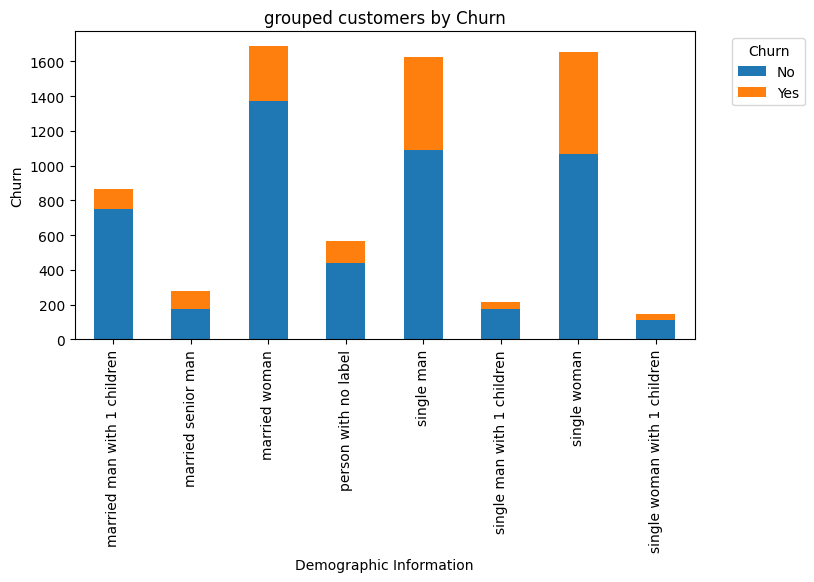

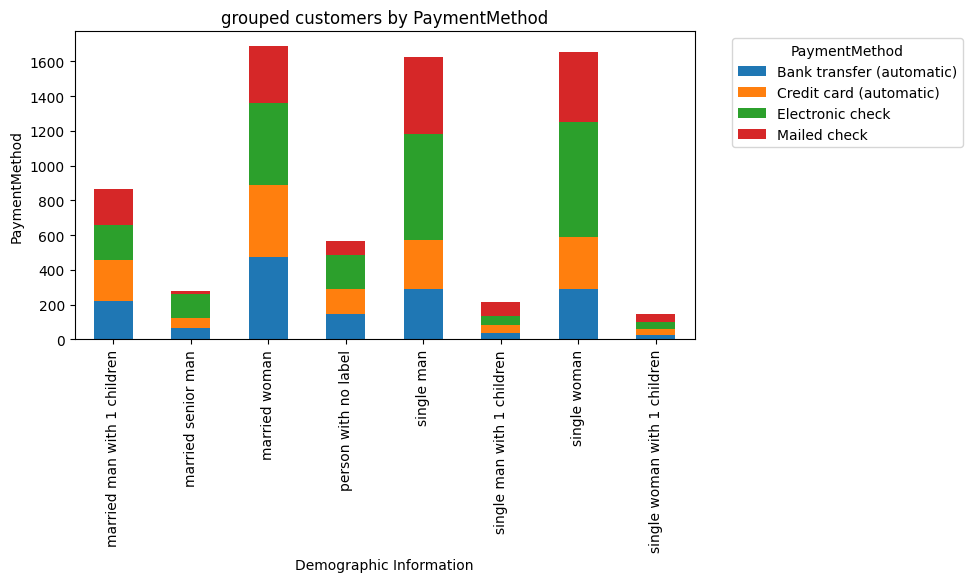

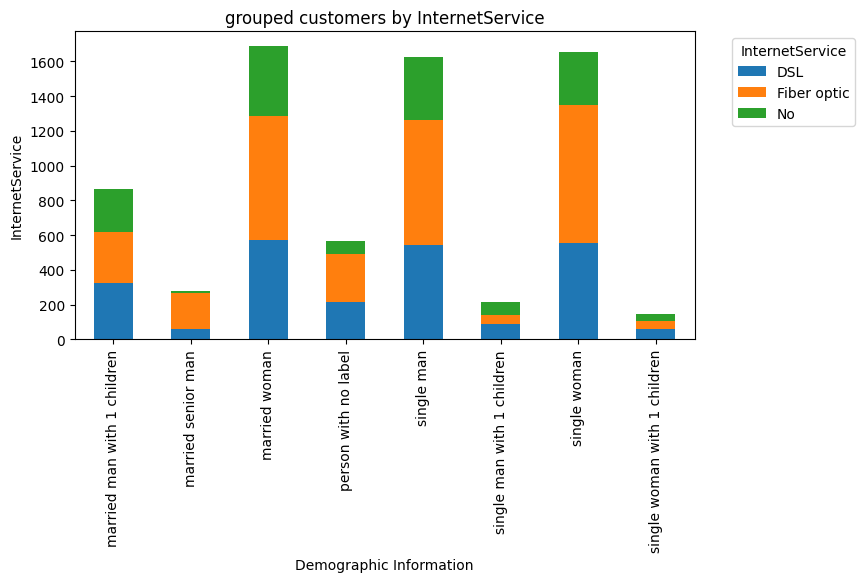

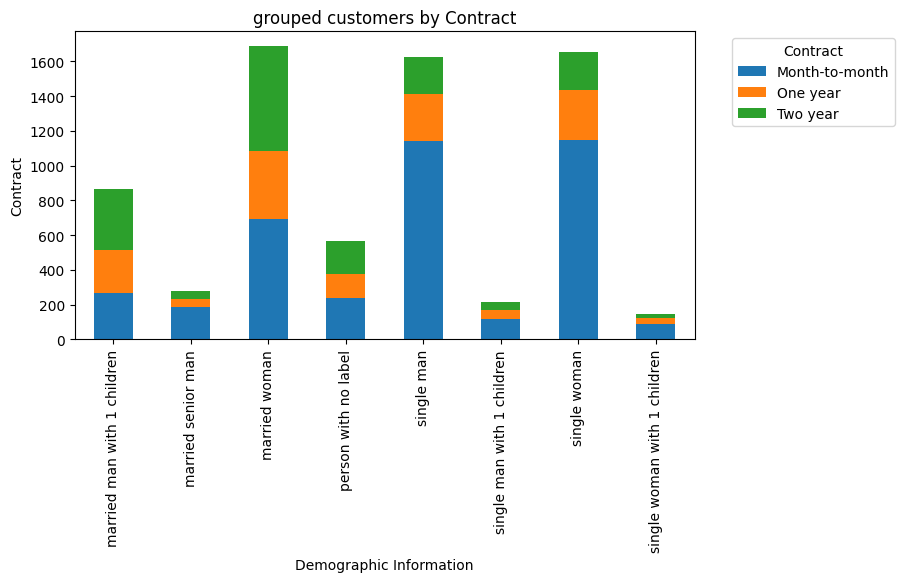

In [36]:
Boxplot=demos[['Demographic','Churn','PaymentMethod','InternetService','Contract']].copy()

def demo_box(df, column_x):
    for col in df.columns:
        if col != 'Demographic':
            stacked_data = Boxplot.groupby([column_x, col]).size().unstack()
            ax=stacked_data.plot(kind='bar', stacked=True, figsize=(8, 4))
            plt.title(f'grouped customers by {col}')
            plt.xlabel('Demographic Information')
            plt.ylabel(f'{col}')
            plt.legend(title=f'{col}', labels=stacked_data.columns, bbox_to_anchor=(1.05, 1), loc='upper left')
            plt.show()
 

demo_box(Boxplot, 'Demographic')




## Reduce Dimensionality based upon multicollinearity shown in initial VIF

In [37]:
demos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customerID         7043 non-null   object 
 1   tenure             7043 non-null   int64  
 2   PhoneService       7043 non-null   object 
 3   MultipleLines      7043 non-null   object 
 4   InternetService    7043 non-null   object 
 5   OnlineSecurity     7043 non-null   object 
 6   OnlineBackup       7043 non-null   object 
 7   DeviceProtection   7043 non-null   object 
 8   TechSupport        7043 non-null   object 
 9   Contract           7043 non-null   object 
 10  PaperlessBilling   7043 non-null   object 
 11  PaymentMethod      7043 non-null   object 
 12  MonthlyCharges     7043 non-null   float64
 13  TotalCharges       7043 non-null   float64
 14  Churn              7043 non-null   object 
 15  Demographic        7043 non-null   object 
 16  StreamingCustomer  7043 

In [38]:
categorical=demos.select_dtypes(include=['object'])
numerical=demos.select_dtypes(exclude=['object'])

In [39]:
encoder=preprocessing.LabelEncoder()

for col in categorical:
    categorical[col]=encoder.fit_transform(categorical[col])



In [40]:
categorical.head()

,customerID,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,Contract,PaperlessBilling,PaymentMethod,Churn,Demographic,StreamingCustomer
0,5375,0,1,0,0,2,0,0,0,1,2,0,2,0
1,3962,1,0,0,2,0,2,0,1,0,3,0,4,0
2,2564,1,0,0,2,2,0,0,0,1,3,1,4,0
3,5535,0,1,0,2,0,2,2,1,0,0,0,4,0
4,6511,1,0,1,0,0,0,0,0,1,2,1,6,0


In [41]:
churn_labeled=pd.concat([categorical,numerical], axis=1)
churn_labeled.head()

,customerID,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,Contract,PaperlessBilling,PaymentMethod,Churn,Demographic,StreamingCustomer,tenure,MonthlyCharges,TotalCharges
0,5375,0,1,0,0,2,0,0,0,1,2,0,2,0,1,29.85,29.85
1,3962,1,0,0,2,0,2,0,1,0,3,0,4,0,34,56.95,1889.50
2,2564,1,0,0,2,2,0,0,0,1,3,1,4,0,2,53.85,108.15
3,5535,0,1,0,2,0,2,2,1,0,0,0,4,0,45,42.30,1840.75
4,6511,1,0,1,0,0,0,0,0,1,2,1,6,0,2,70.70,151.65


In [42]:
pearson=churn_labeled.corr(method='pearson')
spearman=churn_labeled.corr(method='spearman')

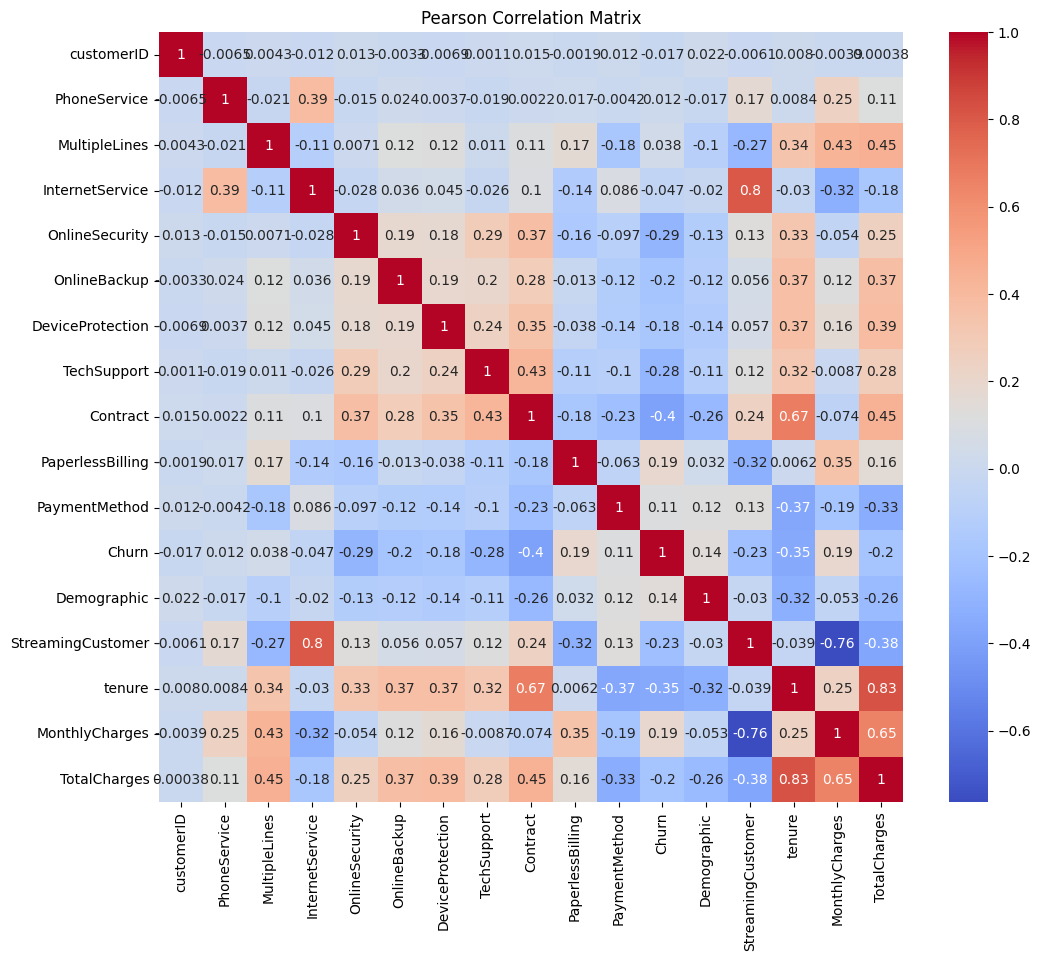

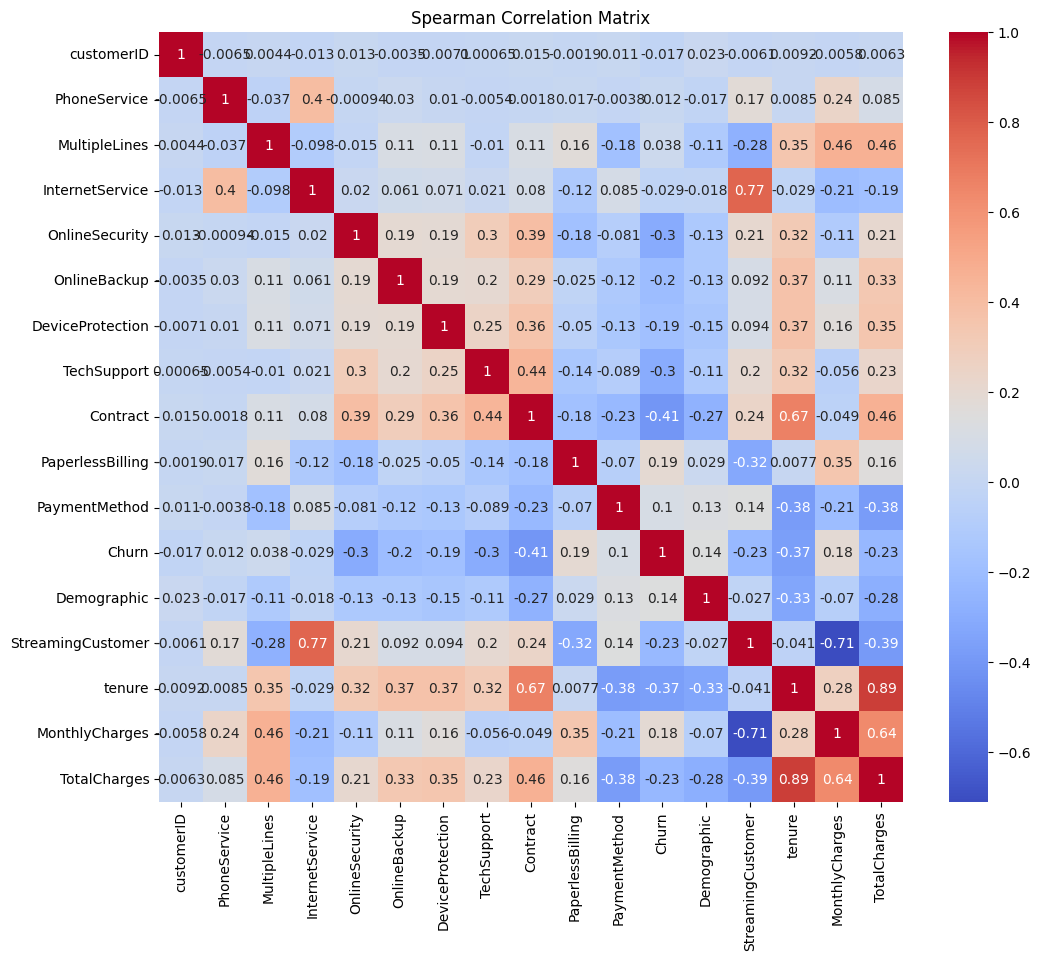

In [43]:
plt.figure(figsize=(12,10))
sns.heatmap(pearson, annot=True, cmap='coolwarm')
plt.title('Pearson Correlation Matrix')
plt.show()

plt.figure(figsize=(12,10))
sns.heatmap(spearman, annot=True, cmap='coolwarm')
plt.title('Spearman Correlation Matrix')
plt.show()

             features        VIF
0          customerID   3.810073
1        PhoneService  22.930362
2       MultipleLines   2.929228
3     InternetService  26.517631
4      OnlineSecurity   2.517175
5        OnlineBackup   2.749062
6    DeviceProtection   3.138894
7         TechSupport   2.815372
8            Contract   4.108492
9    PaperlessBilling   2.918300
10      PaymentMethod   3.406271
11              Churn   1.862500
12        Demographic   3.872385
13  StreamingCustomer  39.482935
14             tenure  15.950507
15     MonthlyCharges  78.986873
16       TotalCharges  16.347106


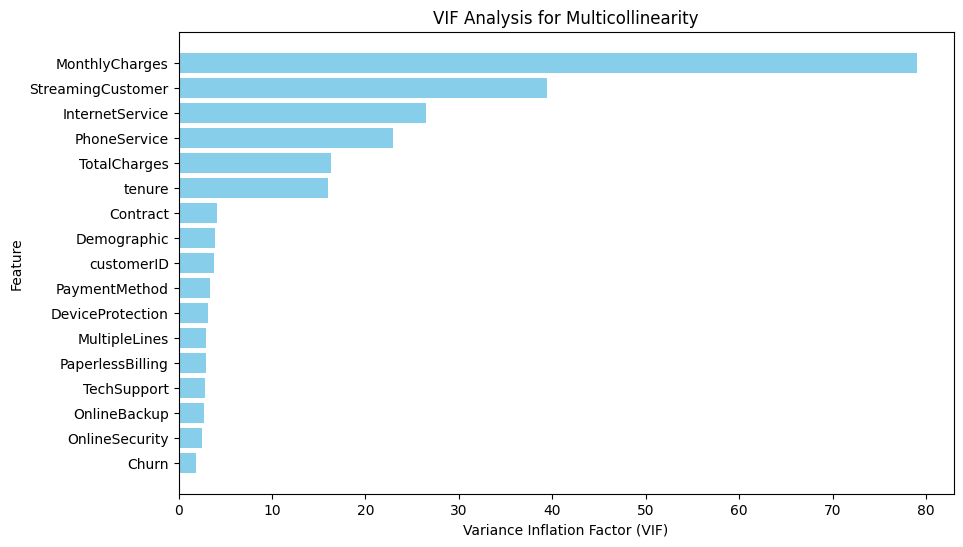

In [44]:
vif_data=pd.DataFrame()
vif_data['features']=churn_labeled.columns
vif_data['VIF']=[variance_inflation_factor(churn_labeled.values,i) for i in range(len(churn_labeled.columns))]
print(vif_data)

vif_data = vif_data.sort_values(by="VIF", ascending=False)


plt.figure(figsize=(10, 6))
plt.barh(vif_data["features"], vif_data["VIF"], color="skyblue")
plt.xlabel("Variance Inflation Factor (VIF)")
plt.ylabel("Feature")
plt.title("VIF Analysis for Multicollinearity")
plt.gca().invert_yaxis()  
plt.show()

PCA using four variables with greatest multicollinearity

In [45]:
reducedone=churn_labeled[['MonthlyCharges','tenure','PhoneService','TotalCharges']].copy(deep=True)
scalar=StandardScaler()
pca=PCA(n_components=2)
scaleddf=scalar.fit_transform(reducedone)
pca.fit(scaleddf)
pca_final=pca.transform(scaleddf)
pca_final=pd.DataFrame(pca_final, columns=['PC1','PC2'])
pca_final.head()


,PC1,PC2
0,-2.429464,-2.346320
1,-0.150725,0.192676
2,-1.428402,0.772345
3,-0.721808,-3.015089
4,-1.138108,0.952297


<Axes: >

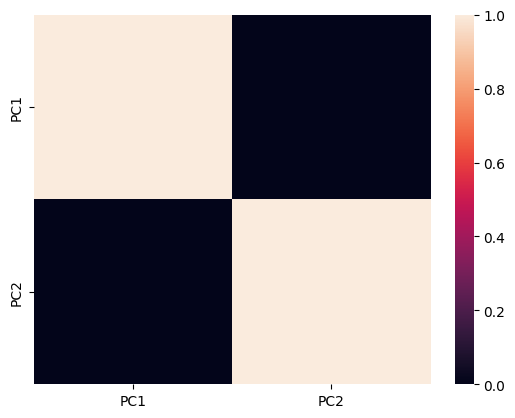

In [46]:
sns.heatmap(pca_final.corr())

return Principal Components to base dataset

In [47]:
churn_labeled.drop(columns=['MonthlyCharges','tenure','PhoneService','TotalCharges'], inplace=True)

final=pd.concat([churn_labeled,pca_final],axis=1)

In [48]:
final=pd.concat([churn_labeled,pca_final],axis=1)

In [49]:
final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customerID         7043 non-null   int64  
 1   MultipleLines      7043 non-null   int64  
 2   InternetService    7043 non-null   int64  
 3   OnlineSecurity     7043 non-null   int64  
 4   OnlineBackup       7043 non-null   int64  
 5   DeviceProtection   7043 non-null   int64  
 6   TechSupport        7043 non-null   int64  
 7   Contract           7043 non-null   int64  
 8   PaperlessBilling   7043 non-null   int64  
 9   PaymentMethod      7043 non-null   int64  
 10  Churn              7043 non-null   int64  
 11  Demographic        7043 non-null   int64  
 12  StreamingCustomer  7043 non-null   int64  
 13  PC1                7043 non-null   float64
 14  PC2                7043 non-null   float64
dtypes: float64(2), int64(13)
memory usage: 825.5 KB


Feature 0: 1.499785
Feature 1: 6.984384
Feature 2: 11.845441
Feature 3: 494.945012
Feature 4: 231.257922
Feature 5: 180.746680
Feature 6: 463.200222
Feature 7: 1056.455417
Feature 8: 197.432607
Feature 9: 61.491201
Feature 10: 108.503958
Feature 11: 307.927191
Feature 12: 125.304997
Feature 13: 334.194415


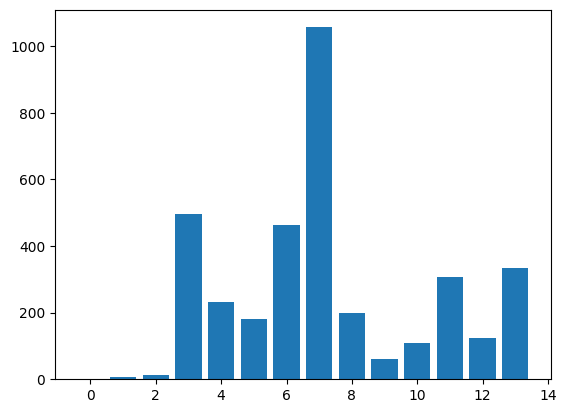

In [50]:
target=final.pop('Churn')
final.insert(0, 'Churn',target)
X=final.iloc[:,1:]
y=final.iloc[:,0]
X_train, X_test, y_train, y_test=train_test_split(X,y, test_size=.2, random_state=1)
feat_select=SelectKBest(score_func=f_classif, k='all')
feat_select.fit(X_train, y_train)
X_train_fs=feat_select.transform(X_train)
X_test_fs=feat_select.transform(X_test)
for i in range(len(feat_select.scores_)):
	print('Feature %d: %f' % (i, feat_select.scores_[i]))
#
plt.bar([i for i in range(len(feat_select.scores_))], feat_select.scores_)
plt.show()

## According to F-Statistic, most important features are Streaming Movies and Demographic